In [1]:
import pandas as pd
import numpy as np
import os
from scipy import stats
from scipy.stats import norm
import math
# acquire
from env import host, user, password
from pydataset import data

# visualize
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(11, 9))
plt.rc('font', size=13)

# turn off pink warning boxes
import warnings
warnings.filterwarnings("ignore")

#sklearn
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split

#Docs
import acquire
import prepare

# Acquire

In [2]:
#acquire for zillow
zillow_df= acquire.get_zillow_data()

In [3]:
#Looking at first 5 values
zillow_df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips,parcelid
0,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0,11721753
1,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0,11289917
2,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0,11705026
3,4.0,3.0,2541.0,880456.0,2003.0,9819.72,6059.0,14269464
4,3.0,2.0,1491.0,107110.0,1955.0,1399.27,6037.0,11446756


In [4]:
#28,000 rows and 8 columns
zillow_df.shape

(28418, 8)

In [5]:
# Displaying readable summary statistics for numeric columns.
zillow_df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,28418.0,3.298086e+00,9.547586e-01,0.00,3.00,3.0,4.00,1.200000e+01
bathroomcnt,28418.0,2.311070e+00,1.017817e+00,0.00,2.00,2.0,3.00,1.100000e+01
calculatedfinishedsquarefeet,28345.0,1.931781e+03,1.013657e+03,240.00,1276.00,1669.0,2319.00,3.564000e+04
taxvaluedollarcnt,28417.0,5.332912e+05,7.063144e+05,1000.00,198412.00,380733.0,630000.00,2.385837e+07
yearbuilt,28322.0,1.963908e+03,2.307474e+01,1878.00,1950.00,1961.0,1980.00,2.016000e+03
taxamount,28417.0,6.486383e+03,8.209046e+03,51.26,2690.92,4703.7,7495.44,2.767978e+05
fips,28418.0,6.050004e+03,2.191571e+01,6037.00,6037.00,6037.0,6059.00,6.111000e+03
parcelid,28418.0,1.307361e+07,3.747577e+06,10711855.00,11523237.25,12611531.0,14163710.25,1.676878e+08


In [6]:
# Running .info() to see datatypes

zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28418 entries, 0 to 28417
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    28418 non-null  float64
 1   bathroomcnt                   28418 non-null  float64
 2   calculatedfinishedsquarefeet  28345 non-null  float64
 3   taxvaluedollarcnt             28417 non-null  float64
 4   yearbuilt                     28322 non-null  float64
 5   taxamount                     28417 non-null  float64
 6   fips                          28418 non-null  float64
 7   parcelid                      28418 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 1.7 MB


In [7]:
#Looking at how many nulls in each column
zillow_df.isnull().sum()

bedroomcnt                       0
bathroomcnt                      0
calculatedfinishedsquarefeet    73
taxvaluedollarcnt                1
yearbuilt                       96
taxamount                        1
fips                             0
parcelid                         0
dtype: int64

In [8]:
# looking at duplicates by unique values
zillow_df.duplicated().value_counts()

False    28392
True        26
dtype: int64

## Acquire Takeways:
- need to drop nulls from calculatedfinishedsquarefeet, unitcnt, taxvaluedollarcnt, yearbuilt, taxamount 
- need to drop duplicates by parcelid (this is a unique identifier)
- all datatypes look good, no changes needed

# Prepare

In [9]:
# Drop all rows with any Null values, assign to df, and verify.
zillow_df= zillow_df.dropna()

In [10]:
#verify nulls were dropped
zillow_df.isnull().sum()

bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
yearbuilt                       0
taxamount                       0
fips                            0
parcelid                        0
dtype: int64

In [11]:
# Count duplicate on a parcelid column
zillow_df['parcelid'].duplicated().sum()

24

In [12]:
#drop duplicated by unique identifier parcelid column
zillow_df.drop_duplicates(subset=['parcelid'], inplace= True)

In [13]:
#Looking at shape after dropping columns
zillow_df.shape

(28292, 8)

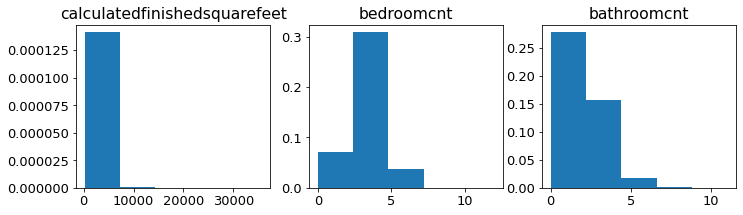

In [14]:
#Looking to before outliers dropped, can see all columns are closer to a normal distribution
prepare.zillow_plot(zillow_df)

## Drop Outliers

In [15]:
prepare.outlier_bound_calculation(zillow_df, 'calculatedfinishedsquarefeet')

For calculatedfinishedsquarefeet the lower bound is -284.5 and  upper bound is 3879.5


In [16]:
#remove outliers from calculatedfinishedsquarefeet
zillow_df= zillow_df[zillow_df.calculatedfinishedsquarefeet > -189.5]
zillow_df= zillow_df[zillow_df.calculatedfinishedsquarefeet < 3550.5]

In [17]:
prepare.outlier_bound_calculation(zillow_df, 'bedroomcnt')

For bedroomcnt the lower bound is 1.5 and  upper bound is 5.5


In [18]:
#remove outliers from bedroomcnt
zillow_df= zillow_df[zillow_df.bedroomcnt >1.5]
zillow_df= zillow_df[zillow_df.bedroomcnt < 5.5]

In [19]:
prepare.outlier_bound_calculation(zillow_df, 'bathroomcnt')

For bathroomcnt the lower bound is 0.5 and  upper bound is 4.5


In [20]:
#remove outliers from bedroomcnt
zillow_df= zillow_df[zillow_df.bathroomcnt > 0.5]
zillow_df= zillow_df[zillow_df.bathroomcnt < 4.5]

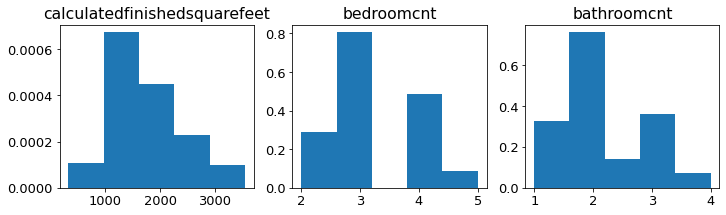

In [21]:
#Looking to see outliers were removed, can see all columns are closer to a normal distribution

prepare.zillow_plot(zillow_df)

Note: Use zillow plot function from prepare.py file

In [22]:
zillow_df.shape #shape after outliers dropped

(25813, 8)

## Prepare takeaways
- dropped 126 rows by dropping duplicates, null values, and outliers for features
- dropped duplicates using parcelid 
- drop outliers to be able to create more accurate models and to scale more accurately

# Explore

In [23]:
# Spilt data
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test= prepare.split_zillow(zillow_df, 'taxvaluedollarcnt')

Note: spilt into train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test datasets

In [24]:
#Creating numeric columns for scaling function
numeric_cols= ['calculatedfinishedsquarefeet']

In [25]:
#using min_max_scaling function from prepare.py
X_train_scaled, X_validate_scaled, X_test_scaled= prepare.min_max_scaler(X_train, X_validate, X_test, numeric_cols)

In [26]:
#dropping target from scaled data
X_train_scaled= X_train_scaled.drop(columns=['taxamount'])
X_validate_scaled= X_validate_scaled.drop(columns=['taxamount'])
X_test_scaled= X_test_scaled.drop(columns=['taxamount'])

In [27]:
#Verify taxamount column was dropped
X_train_scaled.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,yearbuilt,fips,parcelid
17622,3.0,2.0,0.378858,1950.0,6037.0,12482091
26216,5.0,3.0,0.709783,1951.0,6059.0,13889789
6909,3.0,3.0,0.561392,1988.0,6037.0,11344899
4048,5.0,3.0,0.561064,1971.0,6111.0,17246190
24719,2.0,1.0,0.099803,1925.0,6037.0,12359021


In [28]:
#Verify taxamount column was dropped
X_validate_scaled.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,yearbuilt,fips,parcelid
20450,4.0,3.0,0.620158,1969.0,6111.0,17283526
18935,3.0,2.0,0.369993,1949.0,6037.0,11686158
23732,3.0,1.0,0.171044,1951.0,6037.0,12397747
19000,3.0,2.0,0.478661,1969.0,6037.0,11691199
17146,2.0,1.0,0.122784,1953.0,6037.0,11440877


In [29]:
#Verify taxamount column was dropped
X_test_scaled.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,yearbuilt,fips,parcelid
3179,5.0,2.0,0.376559,1964.0,6059.0,14038888
27149,4.0,4.0,0.784636,1986.0,6059.0,14433304
2590,3.0,2.0,0.240972,1962.0,6037.0,12428011
258,2.0,1.0,0.108995,1980.0,6037.0,12504405
23978,2.0,1.5,0.152988,1973.0,6059.0,14073259


In [30]:
#Feature engineering
# parameters: f_regression stats test, give me 3 features
f_selector = SelectKBest(f_regression, k=2)

# find the top 2 X's correlated with y
f_selector.fit(X_train_scaled, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [31]:
#Print to see top features
f_feature

['bathroomcnt', 'calculatedfinishedsquarefeet']

### Statistics

#### Hypothesis 1:
- HO: Square feet has no relationship on tax value dollar count
- Ha: Square feet has a relationship on tax value dollar count

In [32]:
corr, p = stats.pearsonr(train.calculatedfinishedsquarefeet, train.taxvaluedollarcnt)

print(f'corr = {corr:.5f}')
print(f'p = {p:.1f}')

corr = 0.42643
p = 0.0


In [33]:
#set alpha
alpha= 0.05

In [34]:
#Is there a correlation?
# compare our p-value to our alpha:
if p < alpha:
     print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis


#### Hypothesis 2:
- HO: There is no difference between bedroom count and tax value dollar count
- Ha: There is a difference between bedroom count and tax value dollar count

In [35]:
# 2 sample 2 tailed t test
t, p = stats.ttest_ind(train.taxvaluedollarcnt, train.bedroomcnt, equal_var=False)

t, p

(131.56989010958694, 0.0)

In [36]:
#What can we conclude?
if p < alpha:
     print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis


Note: This is not by chance because we reject the null hypothesis.

#### Hypothesis 3:
- HO: There is no difference between bathroom count and tax value dollar count
- Ha: There is a difference between bathroom count and tax value dollar count

In [37]:
# 2 sample 2 tailed t test
t2, p2 = stats.ttest_ind(train.taxvaluedollarcnt, train.bathroomcnt, equal_var=False)

t2, p2

(131.57021568292265, 0.0)

In [38]:
#What is the conclusion?
if p2 < alpha:
     print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis


Note: This is not by chance because we reject the null hypothesis.

## Explore Takeways:
- Top 2 features that correlated with target are bathroom count and calculated finished square feet
- Hypothesis 1:
  - HO: Square feet has no relationship on tax value dollar count
  - Ha: Square feet has a relationship on tax value dollar count
  - We reject the null hypothesis, there is a relationship
- Hypothesis 2:
   - HO: There is no difference between bedroom count and tax value dollar count
   - Ha: There is a difference between bedroom count and tax value dollar count
   - We reject the null hypothesis, this did not happen by chance
- Hypothesis 3:
   - HO: There is no difference between bathroom count and tax value dollar count
   - Ha: There is a difference between bathroom count and tax value dollar count
   - We reject the null hypothesis, this did not happen by chance
  
  
  

# Modeling

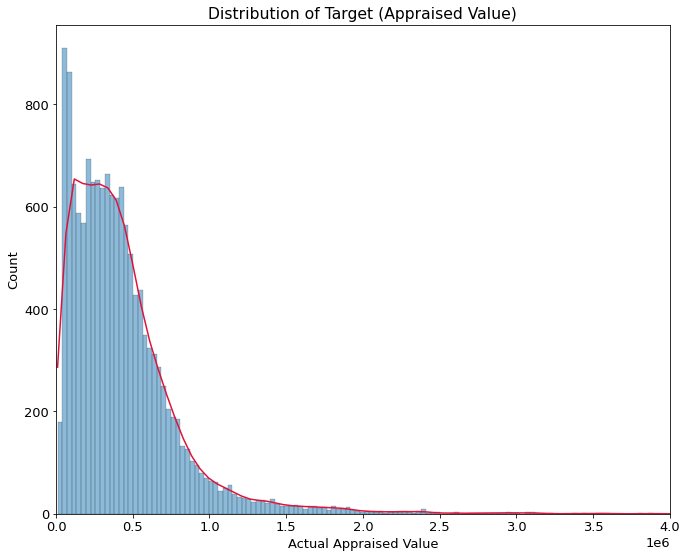

In [39]:
# Is it target normal distribution?
ax= sns.histplot(y_train, kde=True)
plt.xlim(0, 4000000)
ax.lines[0].set_color('crimson')
plt.xlabel('Actual Appraised Value')
plt.title('Distribution of Target (Appraised Value)')
plt.show()

In [40]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values.
#make it a dataframe
y_train= pd.DataFrame({'actual': y_train})
y_validate = pd.DataFrame({'actual': y_validate})
y_test = pd.DataFrame({'actual': y_test})

In [41]:
#verifying actual column was added
y_train.head()

,actual
17622,326735.0
26216,1357426.0
6909,568000.0
4048,93854.0
24719,61457.0


In [42]:
#verifying actual column was added
y_validate.head()

,actual
20450,728000.0
18935,6700650.0
23732,49863.0
19000,1560000.0
17146,336547.0


In [43]:
#verifying actual column was added
y_test.head()

,actual
3179,624378.0
27149,974034.0
2590,424244.0
258,295437.0
23978,366121.0


#### Creating Baseline

In [44]:
#Created baseline
baseline= y_train['actual'].mean()

In [45]:
#Making baseline column
y_train['baseline'] = baseline

In [46]:
#verifying baseline column was added
y_train.head()

,actual,baseline
17622,326735.0,436271.273331
26216,1357426.0,436271.273331
6909,568000.0,436271.273331
4048,93854.0,436271.273331
24719,61457.0,436271.273331


In [48]:
#calculate RMSE for baseline model
rmse_baseline= math.sqrt(mean_squared_error(y_train.actual, y_train.baseline))

In [76]:
print("RMSE for baseline: ", rmse_baseline, "\n\n")

RMSE for baseline:  398649.2186206569 




In [49]:
#creating baseline, actual, and prediction column for validate dataset
y_validate['baseline']= y_train.actual.mean()

In [50]:
#creating features list to use with X_scale
features= ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet']

#### Linear Regression Model

In [51]:
#OLS regression model 1: Train dataset
#Created the object
model1= LinearRegression(normalize= True)
model1.fit(X_train_scaled[features], y_train.actual)

LinearRegression(normalize=True)

In [52]:
#creating prediction column: used model to create predictions and then added it to the y_train
y_train['appraised_value_pred_lr'] = model1.predict(X_train_scaled[features])

In [53]:
#calculate RMSE for model (train dataset)
rmse_train=math.sqrt(mean_squared_error(y_train.actual, y_train.appraised_value_pred_lr))
r2_lr = explained_variance_score(y_train.actual, y_train.appraised_value_pred_lr)

In [54]:
#creating prediction column for validate dataset
y_validate['appraised_value_pred_lr'] = model1.predict(X_validate_scaled[features])

In [55]:
#calculate RMSE for validate model
rmse_validate= math.sqrt(mean_squared_error(y_validate.actual, y_validate.appraised_value_pred_lr))

In [56]:
# creating baseline, actual, and prediction column for test dataset
y_test['baseline']= y_test.actual.mean()
#creating prediction column for test dataset
y_test['appraised_value_pred_lr'] = model1.predict(X_test_scaled[features])

In [57]:
# calculate RMSE for test model
rmse_test= math.sqrt(mean_squared_error(y_test.actual, y_test.appraised_value_pred_lr))

In [58]:
print("RMSE for LinerRegression\nTrain/In-Sample: ", rmse_train, 
      "\n"
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for LinerRegression
Train/In-Sample:  355371.99612718326 

Validation/Out-of-Sample:  394367.72376303555


#### LassoLars Model

In [59]:
# LassoLars Model

# create the model object
lars = LassoLars(alpha=1.0)
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled[features], y_train.actual)

LassoLars()

In [60]:
# predict train
y_train['appraised_value_pred_lars'] = lars.predict(X_train_scaled[features])

In [61]:
# evaluate: rmse
rmse_train2 = mean_squared_error(y_train.actual, y_train.appraised_value_pred_lars)**(1/2)

In [62]:
# predict validate
y_validate['appraised_value_pred_lars'] = lars.predict(X_validate_scaled[features])
# evaluate: rmse
rmse_validate2 = mean_squared_error(y_validate.actual, y_validate.appraised_value_pred_lars)**(1/2)

In [63]:
print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train2, 
      "\nValidation/Out-of-Sample: ", rmse_validate2)

RMSE for Lasso + Lars
Training/In-Sample:  355372.10845950997 
Validation/Out-of-Sample:  394369.84760229435


#### TweedieRegressor Model

In [64]:
# create the model object
glm = TweedieRegressor(power=0, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled[features], y_train.actual)


TweedieRegressor(alpha=0, power=0)

In [65]:
# predict train
y_train['appraised_value_pred_glm'] = glm.predict(X_train_scaled[features])

# evaluate: rmse
rmse_train3 = mean_squared_error(y_train.actual, y_train.appraised_value_pred_glm)**(1/2)

# predict validate
y_validate['appraised_value_pred_glm'] = glm.predict(X_validate_scaled[features])

# evaluate: rmse
rmse_validate3 = mean_squared_error(y_validate.actual, y_validate.appraised_value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=0 & alpha=0\nTraining/In-Sample: ", rmse_train3, 
      "\nValidation/Out-of-Sample: ", rmse_validate3)

RMSE for GLM using Tweedie, power=0 & alpha=0
Training/In-Sample:  355371.99612718326 
Validation/Out-of-Sample:  394367.72378248355


In [75]:
#All score together
print("RMSE for baseline: ", rmse_baseline, "\n\n")

print("RMSE for LinerRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate, "\n\n")


print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train2, 
      "\nValidation/Out-of-Sample: ", rmse_validate2, "\n\n")


print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train3, 
      "\nValidation/Out-of-Sample: ", rmse_validate3)


RMSE for baseline:  398649.2186206569 


RMSE for LinerRegression
Training/In-Sample:  355371.99612718326 
Validation/Out-of-Sample:  394367.72376303555 


RMSE for Lasso + Lars
Training/In-Sample:  355372.10845950997 
Validation/Out-of-Sample:  394369.84760229435 


RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  355371.99612718326 
Validation/Out-of-Sample:  394367.72378248355


#### Linear Regression Modeling (Test dataset)

In [67]:
#creating baseline, actual, and prediction column for validate dataset
y_test['baseline']= y_train.actual.mean()
#creating prediction column for test dataset
y_test['appraised_value_pred_lr'] = model1.predict(X_test_scaled[features])

In [68]:
#calculate RMSE for test model
rmse_test= math.sqrt(mean_squared_error(y_test.actual, y_test.appraised_value_pred_lr))

In [69]:
print("RMSE for LinerRegression\nTest/Out-Sample: ", rmse_test)

RMSE for LinerRegression
Test/Out-Sample:  357127.2075284652


## Modeling Takeways

- All models did better than the baseline.
- Linear Regression has the best RMSE score for the train and validate data (10 % better or $41,522.02 better)


# Additional Deliverables

### Create tax rate column

In [70]:
zillow_df['tax_rate'] =zillow_df['taxamount']/ zillow_df['taxvaluedollarcnt']

In [71]:
#Looking at unique values for the fips columns
zillow_df['fips'].value_counts()

6037.0    16484
6059.0     6926
6111.0     2403
Name: fips, dtype: int64

### Add State Column

In [72]:
zillow_df['state_name'] = 'California'

In [73]:
# add the name of the county based on the FIPS numbers
zillow_df['county_name'] = zillow_df['fips'].map({6037: 'Los Angeles', 6059: 'Orange', 6111: 'Ventura'})

# show counts by county
zillow_df.county_name.value_counts()

Los Angeles    16484
Orange          6926
Ventura         2403
Name: county_name, dtype: int64

(0.0, 0.05)

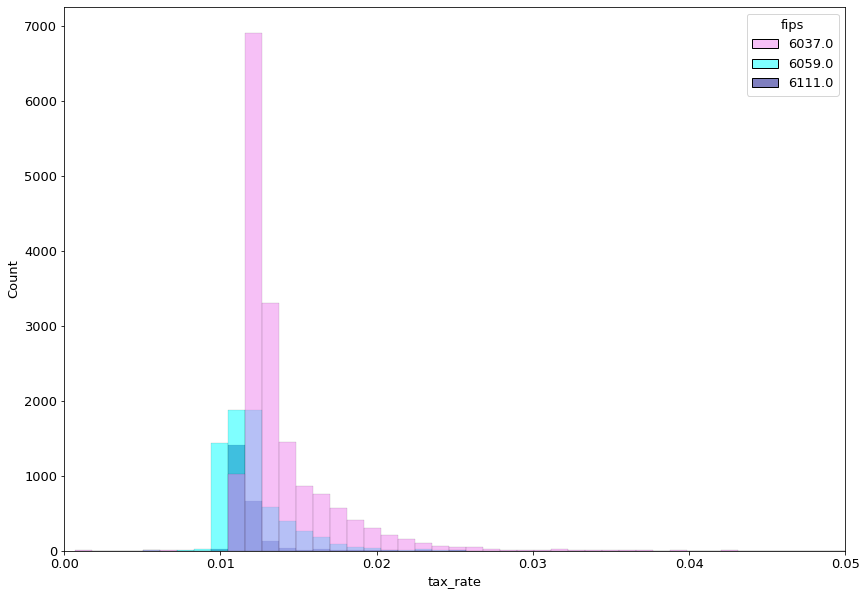

In [74]:
# Plotting tax_rate vs county
plt.figure(figsize=(14,10))
sns.histplot(data=zillow_df, x="tax_rate", hue="fips",kde = False, bins = 750,  palette={6037:'violet', 6059:'aqua', 6111:'navy'})


plt.xlim(0, 0.05)

# Takeways:
- A majority of the tax rate for Los Angeles, Orange, and Ventura falls within about 0.013-0.014 tax rate


# Summary: 

- Recommend the linear regression model
- Model performs 10% better than baseline
- In values of 0 to 100,000 the linear regression model preforms well with the actual vs predicted value.